In [1]:
%%capture
%run Data_Management.ipynb
%run Quality_Assurance.ipynb

***Gateway Drugs***

Do alcohol and cannabis use have any correlation with other drug use?

In [2]:
# Code taken from 10/06 discussion
def plotSKLogistic(x, y, model, figsize=7, title='Training data'):
    plt.figure(figsize=(figsize,figsize))
    pred = x[(model.predict(x) == y), :]
    misPred = x[(model.predict(x) != y), :]
    print(f'{misPred.shape[0]} mispredictions out of {x.shape[0]} attempts')

    plt.scatter(np.dot(pred, model.coef_.T), model.predict(pred), color='k', alpha=.5)
    if misPred.shape[0] > 0:
        plt.scatter(np.dot(misPred, model.coef_.T), 1 - model.predict(misPred), color='r', alpha=.5) # Plot ground truth

    line = sorted(zip(np.dot(x, model.coef_.T), model.predict(x)))
    line_x, line_y = zip(*line)
    plt.plot(line_x, line_y, color='tab:blue', alpha=.5)

    plt.xlabel("Z")
    plt.ylabel("y")
    plt.legend(['Logistic Regression', 'Correct Predictions', 'Mis-predictions'])
    plt.title(title)
    plt.show()


CONFUSION MATRICES: ---------------------------------------
0:
         PREDICTED 0   PREDICTED 1
ACTUAL 0    254          6
ACTUAL 1    50            66


1:
         PREDICTED 0   PREDICTED 1
ACTUAL 0    66          50
ACTUAL 1    6            254


PRECISION AND RECALL: ------------------------------------
              precision    recall  f1-score   support

           0       0.92      0.57      0.70       116
           1       0.84      0.98      0.90       260

    accuracy                           0.85       376
   macro avg       0.88      0.77      0.80       376
weighted avg       0.86      0.85      0.84       376

ACCURACY AND MSE: ----------------------------------------
Accuracy: 0.851063829787234
MSE: 0.14893617021276595


Coefficients:
      alcohol   cannabis
[[-0.47990601  2.36959851]]
56 mispredictions out of 376 attempts


/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but LogisticRegression was fitted with feature names
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not h

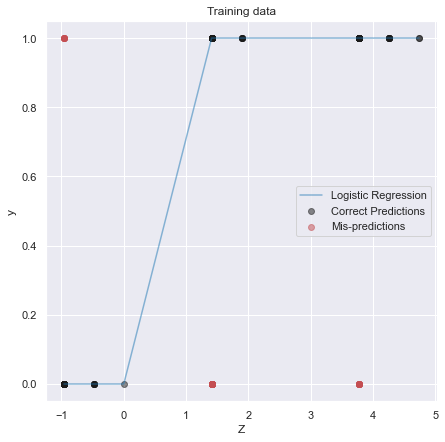

/var/folders/yh/vp33qzld0fz7rzwps6kw6lnh0000gn/T/ipykernel_39406/2317147339.py:54: FutureWarning: this method is deprecated in favour of `Styler.format(precision=..)`
  corr.style.set_precision(3).background_gradient(cmap='RdBu', vmin=-1, vmax=1)


,Alcohol,Cannabis,Hard
Alcohol,1.000,0.106,0.036
Cannabis,0.106,1.000,0.700
Hard,0.036,0.700,1.000


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import seaborn as sns

# Make a copy of the dataframe to use for this model
dfgd = df2.copy()

# Remove rows that claimed they used Semeron
dfgd = dfgd[dfgd["Semer"] == 0]

# Change usage classification:
# 0 - never used
# 1 - used to use
# 2 - current user
for i in range(0,19):
    dfgd[arr[i]].replace({0:0, 1:1, 2:1, 3:2, 4:2, 5:2, 6:2}, inplace=True)
    
# Create new column to specify 'hard' drug usage
# Steps for creating this found here:
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
def hard_drugs(row):
    if row["Amphet"] == 2 or row["Coke"] == 2 or row["Ecstacy"] == 2 or row["LSD"] == 2 or row["Meth"] == 2 or row["Mushrooms"] == 2:
        return 1
    elif row["Amphet"] == 1 or row["Coke"] == 1 or row["Ecstacy"] == 1 or row["LSD"] == 1 or row["Meth"] == 1 or row["Mushrooms"] == 1:
        return 1
    else:
        return 0
dfgd["Hard"] = dfgd.apply(lambda row: hard_drugs(row), axis=1)

# Split data set
# Split the data 80:20
train, test = train_test_split(dfgd, test_size=0.2, random_state=11)
X_train, X_test = train[["Alcohol", "Canabis"]], test[["Alcohol", "Canabis"]]
y_train, y_test = train["Hard"], test["Hard"]

# Create model
lor = LogisticRegression(penalty='l2', max_iter=1000, solver='liblinear').fit(X_train, y_train)
y_pred = lor.predict(X_test)
print_confusion_matrix(y_test, y_pred, names=["0", "1", "2"])
print_precision_recall(y_test, y_pred)
print_accuracy_mse(X_test, y_test, y_pred, lor)

# Print Coefficients
print("Coefficients:")
print("      alcohol   cannabis")
print(lor.coef_)

# Plot logistic regression
plotSKLogistic(X_test.to_numpy(), y_test.to_numpy(), lor)

dfgd = dfgd.rename(columns={"Canabis" : "Cannabis"})
dfgd = dfgd[["Alcohol", "Cannabis", "Hard"]]
corr = dfgd.corr() # Calculate correlations
corr.style.set_precision(3).background_gradient(cmap='RdBu', vmin=-1, vmax=1)

As we can see above, the accuracy of this model is about 0.851. This is a pretty good accuracy and that lets us know that predicting hard drug use from cannabis and alcohol use could be possible. This supports the theory that drugs like alcohol and especially cannabis are gateway drugs.

At the end of the results, we can see the coefficients printed out. The alcohol coefficient is much smaller, telling us that alcohol does not affect the prediction as much. It is also negative which means that alcohol use is slightly negatively correlated with hard drug use. This suggests that cannabis use is a better indicator of hard drug use, which means cannabis is more of a gateway drug.

To use a logistic regression, we had to make the classification binary. That means we lost some information about the drug use of the data points. Current and past users were grouped into one group, and people who have never used hard drugs were grouped into another one. In order to get a better understanding, we can do a multiclass classification using a neural network.

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn import preprocessing

# Make a copy of the dataframe to use for this model
dfgd = df2.copy()

# Remove rows that claimed they used Semeron
dfgd = dfgd[dfgd["Semer"] == 0]

# Change usage classification:
# 0 - never used
# 1 - used to use
# 2 - current user
for i in range(0,19):
    dfgd[arr[i]].replace({0:0, 1:1, 2:1, 3:2, 4:2, 5:2, 6:2}, inplace=True)
    
# Create new column to specify 'hard' drug usage
# Steps for creating this found here:
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
def hard_drugs(row):
    if row["Amphet"] == 2 or row["Coke"] == 2 or row["Ecstacy"] == 2 or row["LSD"] == 2 or row["Meth"] == 2 or row["Mushrooms"] == 2:
        return 2
    elif row["Amphet"] == 1 or row["Coke"] == 1 or row["Ecstacy"] == 1 or row["LSD"] == 1 or row["Meth"] == 1 or row["Mushrooms"] == 1:
        return 1
    else:
        return 0
dfgd["Hard"] = dfgd.apply(lambda row: hard_drugs(row), axis=1)

# Split data set
# Split the data 80:20
train, test = train_test_split(dfgd, test_size=0.2, random_state=4)
X_train, X_test = train[["Alcohol", "Canabis"]], test[["Alcohol", "Canabis"]]
y_train, y_test = train["Hard"], test["Hard"]

# Create model
ann = MLPClassifier(hidden_layer_sizes=(48, 24), activation="relu", solver="sgd", learning_rate_init=0.3, max_iter=500, random_state=8)
ann.fit(X_train, y_train)

# Predictions
y_pred = ann.predict(X_test)
print_confusion_matrix(y_test, y_pred, names=["0", "1", "2"])
print_precision_recall(y_test, y_pred)
print_accuracy_mse(X_test, y_test, y_pred, ann)

CONFUSION MATRICES: ---------------------------------------
0:
         PREDICTED 0   PREDICTED 1
ACTUAL 0    234          4
ACTUAL 1    48            90


1:
         PREDICTED 0   PREDICTED 1
ACTUAL 0    256          56
ACTUAL 1    30            34


2:
         PREDICTED 0   PREDICTED 1
ACTUAL 0    163          39
ACTUAL 1    21            153


PRECISION AND RECALL: ------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.65      0.78       138
           1       0.38      0.53      0.44        64
           2       0.80      0.88      0.84       174

    accuracy                           0.74       376
   macro avg       0.71      0.69      0.68       376
weighted avg       0.78      0.74      0.75       376

ACCURACY AND MSE: ----------------------------------------
Accuracy: 0.7367021276595744
MSE: 0.3670212765957447




Although the accuracy of this neural network is not as high as the logistic regression, it gives us more information about the extent of hard drug use for each data point. However, the predictions for the "1" class do not seem to be very accurate.

Lets see if an SVM classifier will perform better
***USE THIS MODEL - IT IS THE BEST***

CONFUSION MATRICES: ---------------------------------------
0:
         PREDICTED 0   PREDICTED 1
ACTUAL 0    260          5
ACTUAL 1    44            67


1:
         PREDICTED 0   PREDICTED 1
ACTUAL 0    256          57
ACTUAL 1    24            39


2:
         PREDICTED 0   PREDICTED 1
ACTUAL 0    144          30
ACTUAL 1    24            178


PRECISION AND RECALL: ------------------------------------
              precision    recall  f1-score   support

           0       0.93      0.60      0.73       111
           1       0.41      0.62      0.49        63
           2       0.86      0.88      0.87       202

    accuracy                           0.76       376
   macro avg       0.73      0.70      0.70       376
weighted avg       0.80      0.76      0.76       376

ACCURACY AND MSE: ----------------------------------------
Accuracy: 0.7553191489361702
MSE: 0.3324468085106383




/Library/Frameworks/Python.framework/Versions/3.9/lib/python3.9/site-packages/sklearn/base.py:441: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


Text(0, 0.5, 'Cannabis Usage')

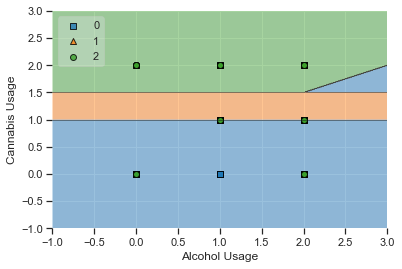

In [6]:
from sklearn import svm
from imblearn.over_sampling import RandomOverSampler
from mlxtend.plotting import plot_decision_regions
import numpy as np
from sklearn.model_selection import validation_curve
import pickle
from joblib import dump

# Make a copy of the dataframe to use for this model
dfsvm = df2.copy()

# Remove rows that claimed they used Semeron
dfsvm = dfsvm[dfsvm["Semer"] == 0]

# Change usage classification:
# 0 - never used
# 1 - used to use
# 2 - current user
for i in range(0,19):
    dfsvm[arr[i]].replace({0:0, 1:1, 2:1, 3:2, 4:2, 5:2, 6:2}, inplace=True)
    
# Create new column to specify 'hard' drug usage
# Steps for creating this found here:
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
def hard_drugs(row):
    if row["Amphet"] == 2 or row["Coke"] == 2 or row["Ecstacy"] == 2 or row["LSD"] == 2 or row["Meth"] == 2 or row["Mushrooms"] == 2:
        return 2
    elif row["Amphet"] == 1 or row["Coke"] == 1 or row["Ecstacy"] == 1 or row["LSD"] == 1 or row["Meth"] == 1 or row["Mushrooms"] == 1:
        return 1
    else:
        return 0
dfsvm["Hard"] = dfsvm.apply(lambda row: hard_drugs(row), axis=1)

# Split data set
# Split the data 80:20
train, test = train_test_split(dfsvm, test_size=0.2, random_state=24)
X_train, X_test = train[["Alcohol", "Canabis"]], test[["Alcohol", "Canabis"]]
y_train, y_test = train["Hard"], test["Hard"]

# Perform oversampling
ros = RandomOverSampler(random_state=4)
X_os, y_os = ros.fit_resample(X_train, y_train)

# Create linear svm model
lsvm = svm.SVC(kernel="linear", gamma="auto", decision_function_shape="ovo", random_state=10)
lsvm.fit(X_os, y_os)

dump(lsvm, 'gatewayModel.joblib') 

# Predictions
y_pred = lsvm.predict(X_test)
print_confusion_matrix(y_test, y_pred, names=["0", "1", "2"])
print_precision_recall(y_test, y_pred)
print_accuracy_mse(X_test, y_test, y_pred, lsvm)


#### plotting ####
plot_decision_regions(X=X_os.values, 
                      y=y_os.values,
                      clf=lsvm, 
                      legend=2)
plt.xlabel('Alcohol Usage')
plt.ylabel('Cannabis Usage')


SVM performs similarly

GRID SEARCH:


In [10]:
from sklearn.model_selection import GridSearchCV

# Make a copy of the dataframe to use for this model
dfsvm = df2.copy()

# Remove rows that claimed they used Semeron
dfsvm = dfsvm[dfsvm["Semer"] == 0]

# Change usage classification:
# 0 - never used
# 1 - used to use
# 2 - current user
for i in range(0,19):
    dfsvm[arr[i]].replace({0:0, 1:1, 2:1, 3:2, 4:2, 5:2, 6:2}, inplace=True)
    
# Create new column to specify 'hard' drug usage
# Steps for creating this found here:
# https://stackoverflow.com/questions/26886653/pandas-create-new-column-based-on-values-from-other-columns-apply-a-function-o
def hard_drugs(row):
    if row["Amphet"] == 2 or row["Coke"] == 2 or row["Ecstacy"] == 2 or row["LSD"] == 2 or row["Meth"] == 2 or row["Mushrooms"] == 2:
        return 2
    elif row["Amphet"] == 1 or row["Coke"] == 1 or row["Ecstacy"] == 1 or row["LSD"] == 1 or row["Meth"] == 1 or row["Mushrooms"] == 1:
        return 1
    else:
        return 0
dfsvm["Hard"] = dfsvm.apply(lambda row: hard_drugs(row), axis=1)

# Split data set
# Split the data 80:20
train, test = train_test_split(dfsvm, test_size=0.2, random_state=24)
X_train, X_test = train[["Alcohol", "Canabis"]], test[["Alcohol", "Canabis"]]
y_train, y_test = train["Hard"], test["Hard"]

# Perform oversampling
ros = RandomOverSampler(random_state=4)
X_os, y_os = ros.fit_resample(X_train, y_train)

# Create svm model
svm_model = svm.SVC()

# Grid search
kernel = ["linear", "poly", "rbf", "sigmoid"]
gamma = ["auto", "scale"]
decision_function_shape = ["ovo", "ovr"]
C = [0.4, 0.6, 0.8, 1.0, 1.2]
random_state=[10]
param_grid = dict(kernel=kernel, decision_function_shape=decision_function_shape, gamma=gamma, random_state=random_state)
grid = GridSearchCV(estimator=svm_model, param_grid=param_grid, n_jobs=-1, cv=3)
grid_result = grid.fit(X_os, y_os)

# summarize results - this code was taken from a lecture example
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.665181 using {'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'linear', 'random_state': 10}
0.665181 (0.010460) with: {'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'linear', 'random_state': 10}
0.640416 (0.011573) with: {'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'poly', 'random_state': 10}
0.663695 (0.008521) with: {'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'rbf', 'random_state': 10}
0.356612 (0.020265) with: {'decision_function_shape': 'ovo', 'gamma': 'auto', 'kernel': 'sigmoid', 'random_state': 10}
0.665181 (0.010460) with: {'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'linear', 'random_state': 10}
0.640416 (0.011573) with: {'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'poly', 'random_state': 10}
0.665181 (0.007313) with: {'decision_function_shape': 'ovo', 'gamma': 'scale', 'kernel': 'rbf', 'random_state': 10}
0.337791 (0.003053) with: {'decision_function_shape': 'ovo', 'gamma

In [11]:
import sys
!{sys.executable} -m pip install mlxtend